## Prueba Científico de Datos - Aflore

### Contexto

**[fuente de datos](https://archive.ics.uci.edu/ml/datasets/congressional+voting+records)**

In [88]:
# Ver contexto de los datos
!cat ../datos/house-votes-84.names

**Definición del problema y solución**

Para el siguiente ejercicio, me enfocaré en buscar información que ayude a responder la pregunta, ¿es la aprobación de leyes en la rama legislativa determinada por la evidencia o la ideología?. Para contribuir a su respuesta asumiré que para cada ley propuesta existe algún grado de evidencia sobre su eficacia. Si esta evidencia existe y los legisladores se basan en ella para apoyar o rechazar un proyecto de ley, se esperaría que el partido al que pertenezca un legislador no debería tener un peso alto en sus decisiones.

Teniendo en cuenta estos supuestos, en este ejercicio analizaré la relevancia que tiene la pertenencia a un partido en las decisiones de representantes a la cámara del congreso de los Estados Unidos en sus votaciones, mediante un análisis exploratorio de las votaciones históricas y luego mediante la creación y entrenamiento de un modelo de aprendizaje automático/*machine learning* que intente pronosticar el partido político de un representante basado en sus votaciones históricas.

### Importar módulos y datos

Importar módulos utilizados en este cuaderno

In [68]:
# Módulos utilizados para guardar modelos
import joblib

# Procesamiento de datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Modelación
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_curve, auc, roc_auc_score, \
                            RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [69]:
%%bash
# Visualizar primeras filas para entender estructura de los datos
head -n 5 ../datos/house-votes-84.data

republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


Importar datos

In [70]:
# Importar datos con columnas nombradas correctamente
columns = ['party', 'handicapped_infants', 'water_project', 'budget_resolution', 'physicial_fee_freeze', 'el_salvador_aid', 
           'religious_groups_schools', 'anti_satellite_test_ban', 'aid_contras', 'mx_missile', 'immigration',
           'synfuels_cutback', 'education_spending', 'superfund_right_to_sue', 'crime', 'duty_free_exports', 
           'export_admin_act_south_africa']
data = pd.read_csv("../datos/house-votes-84.data", names=columns)

# Visualizar datos
data.head()

,party,handicapped_infants,water_project,budget_resolution,physicial_fee_freeze,el_salvador_aid,religious_groups_schools,anti_satellite_test_ban,aid_contras,mx_missile,immigration,synfuels_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_admin_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


### Análisis exploratorio y limpieza de los datos

En esta sección, exploraré las principales características del conjunto de datos y de las columnas contenidas, tanto de forma individual como la relación entre las variables de interés, de acuerdo al problema que intento resolver.

#### Estructura de los datos

In [6]:
print(f"""
Columnas: \t{data.shape[1]:,d}
Filas: \t\t{data.shape[0]:,d}

Columnas y tipos:
{data.dtypes}
""")


Columnas: 	17
Filas: 		435

Columnas y tipos:
party                            object
handicapped_infants              object
water_project                    object
budget_resolution                object
physicial_fee_freeze             object
el_salvador_aid                  object
religious_groups_schools         object
anti_satellite_test_ban          object
aid_contras                      object
mx_missile                       object
immigration                      object
synfuels_cutback                 object
education_spending               object
superfund_right_to_sue           object
crime                            object
duty_free_exports                object
export_admin_act_south_africa    object
dtype: object



#### Datos en blanco/missing

In [7]:
# Datos en blanco?
missing = data.isna().sum().sum()
print(f"Datos en blanco: {missing:,d}")

Datos en blanco: 0


Debería haber datos en blanco, de acuerdo a la documentación. Como se ve en el siguiente bloque. Esto se debe a que la documentación se refiere a los '`?`' como datos en blanco.

Sin embargo, como también explica la documentación, no es correcto que los valores `'?'` se refieran a valores desconocidos, sino a votos que no son a favor ni en contra (votos neutros). Es decir, estos no son datos faltantes o en blanco, son un valor definido, y deben tratarse como tal.

Adicional a esto, hay una discrepancia entre el conteo de votos neutros incluido en la documentación y el obtenido en el siguiente bloque. De acuerdo a los resultados observados, pareciese que la documentación trocara los valores de cada columna una posición hacia abajo. Para tener más certeza de que esto es un error en la documentación, conté los valores utilizando Bash (dos bloques más abajo) en vez de Python, donde obtuve los mismos resultados. Por lo tanto, asumiré que esto es un error en la documentación, no en los datos.

In [75]:
for idx, col in enumerate(columns):
    print(f"{idx + 1:2}. {col}\t{(data[col] == '?').sum()}")

 1. party	0
 2. handicapped_infants	12
 3. water_project	48
 4. budget_resolution	11
 5. physicial_fee_freeze	11
 6. el_salvador_aid	15
 7. religious_groups_schools	11
 8. anti_satellite_test_ban	14
 9. aid_contras	15
10. mx_missile	22
11. immigration	7
12. synfuels_cutback	21
13. education_spending	31
14. superfund_right_to_sue	25
15. crime	17
16. duty_free_exports	28
17. export_admin_act_south_africa	104


In [77]:
%%bash
# Validar si obtengo el mismo conteo de '?' en Bash
cut -f2 -d, ../datos/house-votes-84.data | sort | uniq -c

     12 ?
    236 n
    187 y


En conclusuión, estos datos no contienen valores en blanco (missing), por lo que no es necesario hacerles algún tratamiento adicional (por ejemplo, imputarlos)

#### Análisis univariado

Partido

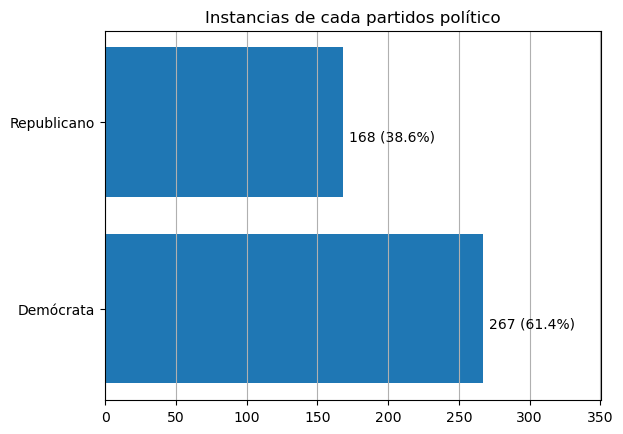

In [11]:
# Graficar conteo de instancias en cada partido
party_count = data['party'].value_counts()
fig, ax = plt.subplots()
ax.barh(y=party_count.index, width=party_count)
ax.set_title("Instancias de cada partidos político")
ax.grid(axis='x')
ax.set_yticks(['republican', 'democrat'])
ax.set_yticklabels(['Republicano', 'Demócrata'])

ax.set_xlim(xmax=ax.get_xlim()[1] * 1.25)

for idx, party in enumerate(party_count.index):
    counter = party_count.loc[party, ]
    ax.text(y=idx - 0.1, 
            x=party_count.loc[party, ] + 4, 
            s=f"{counter} ({counter / data.shape[0] * 100:.1f}%)")
plt.show()

Votaciones

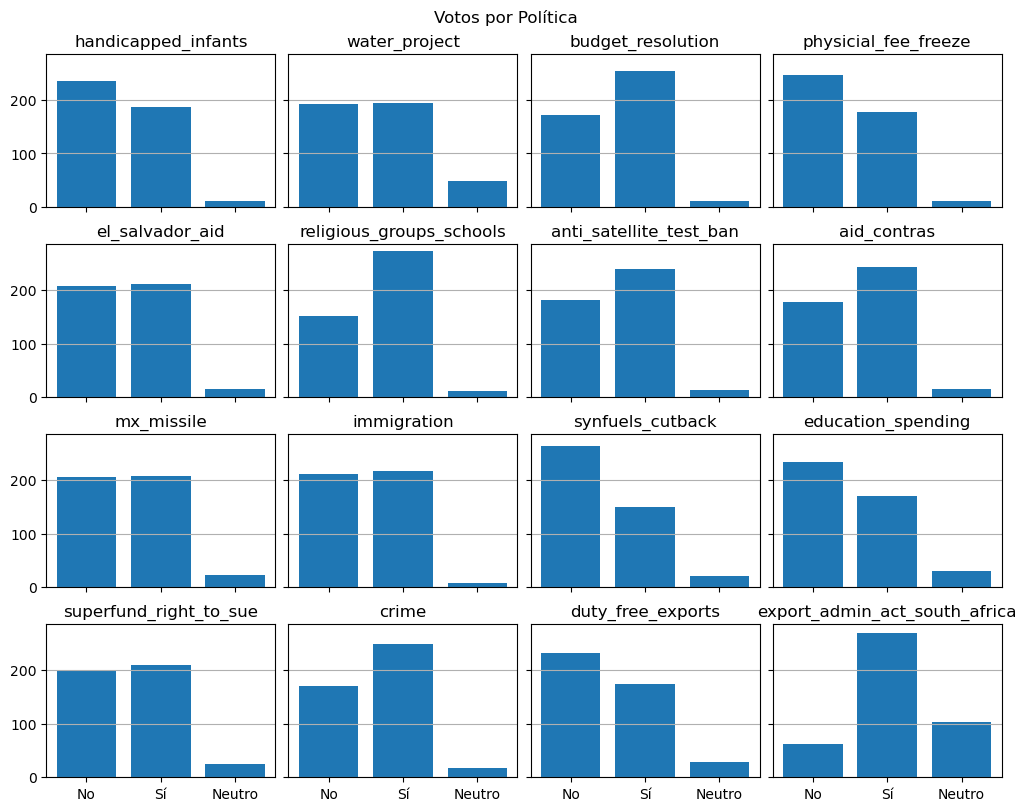

In [15]:
# Calcular dimensiones de matriz de gráficos
plots_num = len(data.columns) - 1
rows_cols_num = int(np.sqrt(plots_num) // 1)

# Crea figura que contendrá los gráficos
fig, axs = plt.subplots(ncols=rows_cols_num, 
                        nrows=rows_cols_num, 
                        figsize=(10, 8), 
                        sharex=True, 
                        sharey=True, 
                        layout='constrained')
fig.suptitle("Votos por Política")

# Graficar proporción de votos de cada una de las votaciones
for idx, col in enumerate(columns[1:]):
        voting_count = data[col].value_counts()
        curr_row = idx // rows_cols_num
        curr_col = idx % rows_cols_num
        curr_ax = axs[curr_row][curr_col]
        curr_ax.bar(x=voting_count.index, height=voting_count)
        curr_ax.grid(axis='y')
        curr_ax.set_title(col)
        curr_ax.set_xticks(['n', 'y', '?'])
        curr_ax.set_xticklabels(['No', 'Sí', 'Neutro']);

#### Análisis bivariado

Para el análisis vibariado, me concentraré en encontrar políticas que me permitan predecir el partido de un representante en función de cómo haya votado en cada una de las 16 votaciones contenidas en el conjunto de datos.


En primer lugar, se inspeccionará visualmente si las variables de votaciones son buenas candidatas para incluir en el modelo como predictores del partido político. El siguiente bloque contiene el gráfico que muestra la proporción de votos de cada partido en cada una de las votaciones.

En los siguientes gráficos, se puede observar que las proporciones de cada sentido de las votaciones varían notablemente dependiendo del partido. Esto indica, que estas variables tienen un buen poder predictivo del partido al que pertenece el votante.

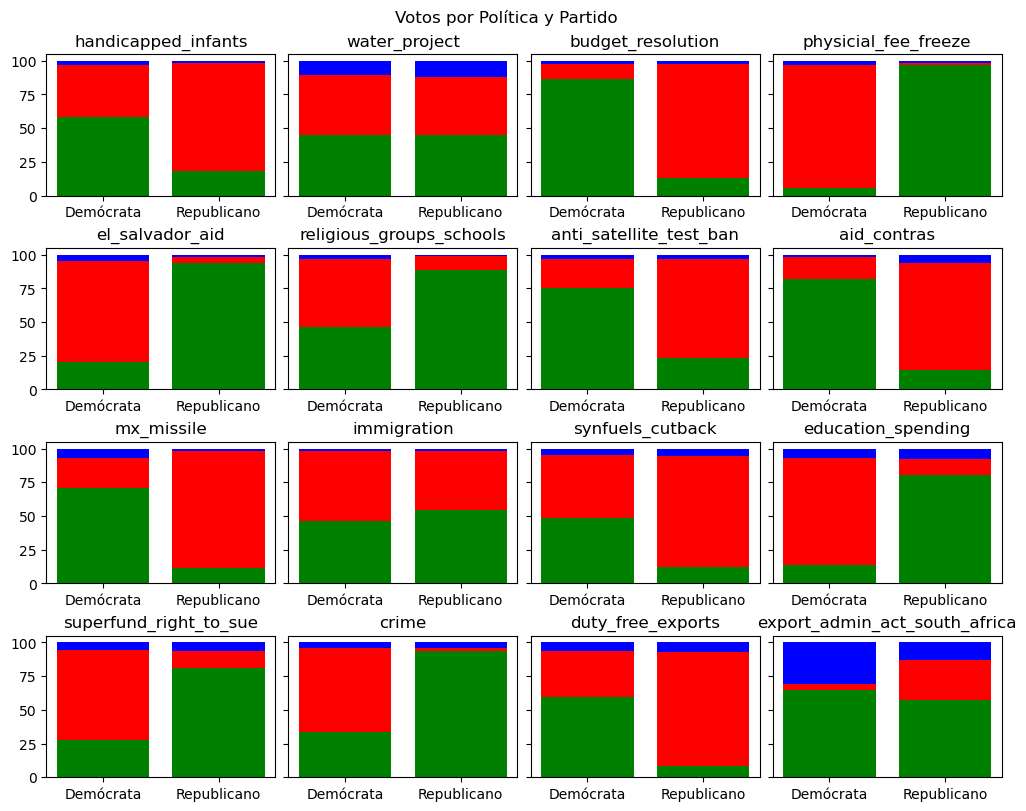

In [66]:
def count_value(col, value):
    counter =  col.value_counts().loc[value]
    percentage = counter / col.shape[0] * 100
    return percentage


# Calcular dimensiones de matriz de gráficos
plots_num = len(data.columns) - 1
rows_cols_num = int(np.sqrt(plots_num) // 1)

fig, axs = plt.subplots(ncols=rows_cols_num, 
                        nrows=rows_cols_num, 
                        figsize=(10, 8), 
                        sharey=True, 
                        layout='constrained')
fig.suptitle("Votos por Política y Partido")

for idx, col in enumerate(data.columns[1:]):
    data_party = data.groupby('party')\
                    .agg(yes=(col, lambda x: count_value(x, 'y')), 
                        no=(col, lambda x: count_value(x, 'n')), 
                        undefined=(col, lambda x: count_value(x, '?')))

    curr_row = idx // rows_cols_num
    curr_col = idx % rows_cols_num
    curr_ax = axs[curr_row][curr_col]
    
    curr_ax.bar(data_party.index, data_party['yes'], color='green')
    curr_ax.bar(data_party.index, data_party['no'], bottom=data_party['yes'], color='red')
    curr_ax.bar(data_party.index, data_party['undefined'], bottom=data_party['yes'] + data_party['no'], color='blue')
    curr_ax.set_title(col)
    curr_ax.set_xticks(['democrat', 'republican'])
    curr_ax.set_xticklabels(['Demócrata', 'Republicano'])

Pasando al análisis cuantitativo, es necesario evaluar que los predictores estén correlacionados con la variable a predecir (partido). En este caso, estamos tratando con variables nominales (partido vs votación X) donde una de las variables tiene más de dos valores (No, Sí, Neutro), por lo que puedo utilizar el coeficiente de Cramer para calcular la correlación entre el partido y cada una de las votaciones.

El coeficiente de Cramer se calcula en el siguiente bloque, donde se observa que efectivamente existe una relación entre la variable a pronosticar y sus predictores. Este resultado es evidencia adicional del poder de cada una de estas variables para predecir el partido político del votante/representante.

In [3]:
# Codificar todas las variables por valores numéricos
codes_to_replace = {'republican': 1,
                    'democrat': 0, 
                    'n': 0, 
                    'y': 1, 
                    '?': 2}

data_encoded = data.replace(codes_to_replace)

# Definir función para calcular V de Cramer
def v_cramer(var1, var2):
    """ Calculates Cramer's V for two nominal variables
    
    Keyword arguments:
    var1 - First nominal variables
    var2 - Second nominal variable
    """
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    stat = stats.chi2_contingency(crosstab)[0] 
    obs = np.sum(crosstab)
    mini = min(crosstab.shape) - 1
    
    return (stat/(obs*mini))

# Calcular V de Cramer entre Partido y cada una de la variables de votación
v_cramers = []
for x_train_col in data.columns[1:]:
    cramer = v_cramer(data_encoded['party'], data_encoded[x_train_col])
    v_cramers.append(np.round(cramer, 2))

# Imprimir resultados, de mayor a menor valor
v_cramers = pd.Series(v_cramers, index=data.columns[1:])
print('V de Cramer (Partido vs Votación X):')
v_cramers.sort_values(ascending=False)

V de Cramer (Partido vs Votación X):


physicial_fee_freeze             0.83
budget_resolution                0.55
el_salvador_aid                  0.51
education_spending               0.47
aid_contras                      0.44
mx_missile                       0.40
crime                            0.38
superfund_right_to_sue           0.29
duty_free_exports                0.27
anti_satellite_test_ban          0.26
religious_groups_schools         0.18
handicapped_infants              0.17
synfuels_cutback                 0.14
export_admin_act_south_africa    0.14
immigration                      0.01
water_project                    0.00
dtype: float64

### Modelación

De acuerdo al contexto definido en la sección anterior, en esta sección se define, entrena y evalua un modelo para pronosticar el partido político de un representante de acuerdo a su votación histórica.

#### Preparacion de los datos

Codificar todas las variables, de `strings` a números, para utilizarlas como insumos en el modelo.

In [78]:
# Codificar todas las variables por valores numéricos
codes_to_replace = {'republican': 1,
                    'democrat': 0, 
                    'n': 0, 
                    'y': 1, 
                    '?': 2}

data_encoded = data.replace(codes_to_replace)

A pesar de que la variable independiente no es completamente balanceada, el desbalance está dentro de un rango razonable. Igualmente, más adelante validaré si el desbalance observado tiene algún impacto sobre el deesempeño del modelo, mediante el uso de métricas de desempeño que tengan en cuenta este desbalance.

In [79]:
data_encoded['party'].value_counts() / data_encoded.shape[0] * 100

0    61.37931
1    38.62069
Name: party, dtype: float64

Dividir en conjunto de datos de entrenamiento y validación.

In [80]:
# Dividir datos en conjunto de entrenamiento y validacion
X_train, X_test, y_train, y_test = train_test_split(data_encoded.iloc[:,1:],
                                                    data_encoded.iloc[:, 0],
                                                    test_size=0.2, 
                                                    random_state=67)

print(f"""
Observaciones entrenamiento: \t{X_train.shape[0]:,d}
Observaciones validación: \t{X_test.shape[0]:,d}
""")


Observaciones entrenamiento: 	348
Observaciones validación: 	87



#### Entrenamiento de modelo

Entrenar modelo utilizando `GridSearchCV` para encontrar mejor combinación de hiperparámetros.

In [81]:
# Definir modelo y construir parrilla de evaluación de hiperparámetros
classifier = CategoricalNB()
grid = {'alpha': np.arange(0.1, 1.05, 0.1), 
        'fit_prior': [True, False]}
grid_search_clf = GridSearchCV(classifier, 
                               param_grid=grid, 
                               scoring='accuracy', 
                               cv=5)

# Encontrar mejor modelo evaluando hiperparámetros de la parrilla
grid_search_clf.fit(X_train, y_train)

# Seleccionar mejor modelo
best_clf = grid_search_clf.best_estimator_

#### Evaluación de modelo

Evaluar mejor modelo contra conjunto de datos de validación.

In [82]:
# Pronostico basado en conjunto de validación
y_test_predict = best_clf.predict(X_test)

# Probabilidades pronosticadas
y_test_prob = best_clf.predict_proba(X_test, )
y_test_prob = [row[1] for row in y_test_prob]

Matriz de confusión

Text(0.5, 1.0, 'Matriz de Confusión')

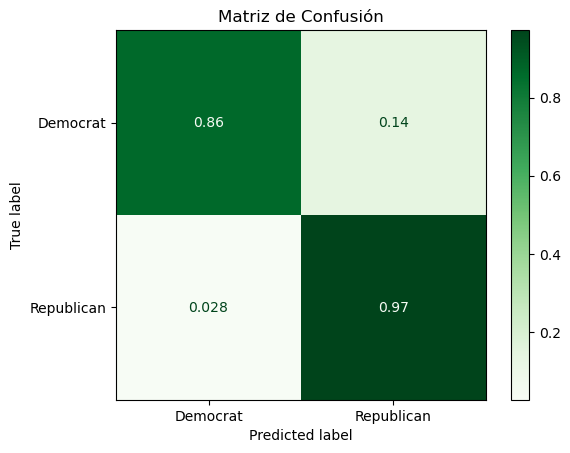

In [83]:
confusion = confusion_matrix(y_test, 
                             y_test_predict, 
                             normalize='true')
confusion_disp = ConfusionMatrixDisplay(confusion, 
                                        display_labels=['Democrat', 'Republican']) 
confusion_disp.plot(cmap='Greens')
confusion_disp.ax_.set_title('Matriz de Confusión')

Métricas de desempeño

In [86]:
# Calcular métricas de desempeño
accuracy = accuracy_score(y_test, y_test_predict)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_predict)
f1 = f1_score(y_test, y_test_predict)

# Imprimir resultados
print(f"""
Accuracy: \t\t{accuracy:.2f}
Accuracy (balanceada): \t{balanced_accuracy:.2f}
F1: \t\t\t{f1:.2f}
""")



Accuracy: 		0.91
Accuracy (balanceada): 	0.92
F1: 			0.90



Curva ROC

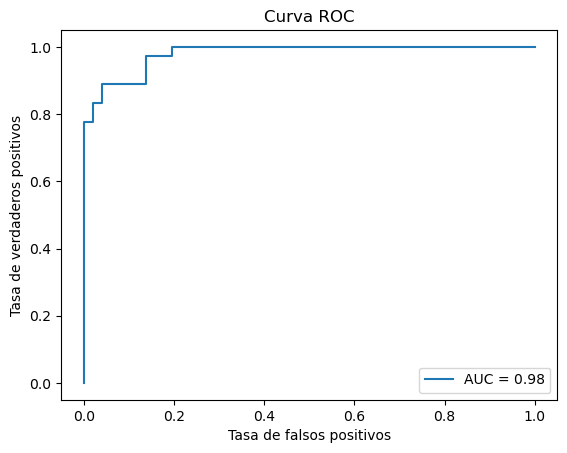

In [87]:
# Calcular valores de la curve ROC
area_under_roc = roc_auc_score(y_test, y_test_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
roc_curve_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_curve_display.plot()
roc_curve_display.ax_.set_title("Curva ROC")
roc_curve_display.ax_.set_xlabel("Tasa de falsos positivos")
roc_curve_display.ax_.set_ylabel("Tasa de verdaderos positivos")
plt.show()

Exportar modelo

In [18]:
model_name = '../modelos/naive_bayes_classifier.pkl'
joblib.dump(best_clf, model_name, compress=9)

['../models/naive_bayes_classifier.pkl']

### Conclusión

Tanto el análisis exploratorio de los datos como la evaluación del modelo entrenado, muestran que el sentido en que vota un representante tiene un poder predictivo muy alto sobre cuál es el partido al que pertenece. Adiconal a esto, el poder predictivo del modelo es notablemente superior para pronosticas si un representante es republicano que si es demócrata(accuracy de 97% vs 86%, respectivamente), lo cual indica, bajo los supuestos mencionados inicialmente, que los representantes republicanos toman sus decisiones de votación más basados en consideraciones ideológicas que sus pares demócratas.